In [1]:
from preamble import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


In [3]:
df = pd.read_csv('./data/temp/j_all.csv')

In [4]:
df.dropna(inplace=True)

In [5]:
df.head()

,observation_time,reservoir_id,input,output,height
0,2023-01-01 00:00:00,1,79.20,102.76,4.97
1,2023-01-01 01:00:00,1,107.09,119.92,4.99
2,2023-01-01 02:00:00,1,143.67,124.54,5.01
3,2023-01-01 03:00:00,1,144.95,80.16,5.01
4,2023-01-01 04:00:00,1,159.06,104.88,5.02


In [6]:
df['observation_time'] = pd.to_datetime(df['observation_time'])
df['timestamp'] = df['observation_time'].astype('int64') // 10**9
df_dropped = df.drop(['observation_time', 'reservoir_id', 'height'], axis=1)
df_dropped.head()

,input,output,timestamp
0,79.20,102.76,1672531200
1,107.09,119.92,1672534800
2,143.67,124.54,1672538400
3,144.95,80.16,1672542000
4,159.06,104.88,1672545600


In [7]:
X = df_dropped.reset_index(drop=True)
y = df_dropped['output'].values.reshape(-1, 1)

In [8]:
X.head()

,input,output,timestamp
0,79.20,102.76,1672531200
1,107.09,119.92,1672534800
2,143.67,124.54,1672538400
3,144.95,80.16,1672542000
4,159.06,104.88,1672545600


In [9]:
y.shape

(15738, 1)

In [10]:
train_size = int(len(X) * 0.7)

trainset_feature = X[:train_size]
trainset_target = y[:train_size]
testset_feature = X[train_size:]
testset_target = y[train_size:]

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler_feature = MinMaxScaler()
train_feature_scaled = scaler_feature.fit_transform(trainset_feature)
test_feature_scaled = scaler_feature.transform(testset_feature)

scaler_target = MinMaxScaler()
train_target_scaled = scaler_target.fit_transform(trainset_target)
test_target_scaled = scaler_target.transform(testset_target)

In [12]:
valid_size = int(train_feature_scaled.shape[0] * 0.9)

train_feature_scaled2 = train_feature_scaled[:valid_size]
train_target_scaled2 = train_target_scaled[:valid_size]
valid_feature_scaled = train_feature_scaled[valid_size:]
valid_target_scaled = train_target_scaled[valid_size:]

In [13]:
import pickle

with open('./model/scaler_feature_lstm_v11.pkl', 'wb') as f:
  pickle.dump(scaler_feature, f)
with open('./model/scaler_target_lstm_v11.pkl', 'wb') as f:
  pickle.dump(scaler_target, f)

In [14]:
def split_dataset(data, target, seq_len, pred_len):
  X, y = [], []
  for i in range(data.shape[0] - (seq_len + pred_len)):
    X.append(data[i:i + seq_len, :])
    y.append(target[i + seq_len:i + seq_len + pred_len])
  return np.array(X), np.array(y)

In [15]:
seq_len = 168  # 과거 7일 (시간 단위)
pred_len = 1  # 이후 1시간 예측

X_train, y_train = split_dataset(train_feature_scaled2, train_target_scaled2, seq_len, pred_len)
X_valid, y_valid = split_dataset(valid_feature_scaled, valid_target_scaled, seq_len, pred_len)
X_test, y_test = split_dataset(test_feature_scaled, test_target_scaled, seq_len, pred_len)

print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(9745, 168, 3) (933, 168, 3) (4553, 168, 3) (9745, 1, 1) (933, 1, 1) (4553, 1, 1)


In [16]:
from torch.utils.data import DataLoader, TensorDataset

# batch_size = 128
X_train_tensor, y_train_tensor = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_valid_tensor, y_valid_tensor = torch.tensor(X_valid).float(), torch.tensor(y_valid).float()
X_test_tensor, y_test_tensor = torch.tensor(X_test).float(), torch.tensor(y_test).float()

loader_train = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), shuffle=True,
                                           batch_size=128)
loader_valid = DataLoader(TensorDataset(X_valid_tensor, y_valid_tensor), shuffle=True,
                                           batch_size=128)
loader_test = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), shuffle=False,
                                          batch_size=128)

In [17]:
class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTMModel, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    lstm_out, _ = self.lstm(x)
    last_out = lstm_out[:, -1, :]
    out = self.fc(last_out)
    return out

input_size = X_train.shape[2]
hidden_size = 50
output_size = pred_len

model = LSTMModel(input_size, hidden_size, output_size).to(device)
print(model)

LSTMModel(
  (lstm): LSTM(3, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


In [18]:
import torch.optim as optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
def evaluate(model, valid_dataset, loss_fn, device):
  val_loss = 0
  model.eval()
  with torch.no_grad():
    for X, y in valid_dataset:
      X_batch, y_batch = X.to(device), y.to(device)
      out = model(X_batch)
      loss = loss_fn(out, y_batch)
      val_loss += loss.item()
  return val_loss

In [20]:
num_epochs = 300
best_valid_loss = float('inf')
loss_history = []
model.to(device)

for epoch in range(num_epochs):
  model.train() 
  train_loss = 0
  for X, y in loader_train:
    X_batch, y_batch = X.to(device), y.to(device)

    out = model(X_batch)
    loss = loss_fn(out, y_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  loss_history.append(train_loss / len(loader_train.dataset))
  valid_loss = evaluate(model, loader_valid, loss_fn, device)
  print(f'Epoch : {epoch + 1} / {num_epochs}')
  print(f'Train Loss : {train_loss}')
  print(f'Valid Loss : {valid_loss}')
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), './model/1hour_best_lstm_model.pt')

c:\DevTool\anaconda3\envs\torch_book\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([128, 1, 1])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\DevTool\anaconda3\envs\torch_book\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([17, 1, 1])) that is different to the input size (torch.Size([17, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\DevTool\anaconda3\envs\torch_book\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([37, 1, 1])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. 

Epoch : 1 / 300
Train Loss : 13.1658329104539
Valid Loss : 0.020831306232139468
Epoch : 2 / 300
Train Loss : 0.13727260939776897
Valid Loss : 0.017006380949169397
Epoch : 3 / 300
Train Loss : 0.07258716730575543
Valid Loss : 0.004055289085954428
Epoch : 4 / 300
Train Loss : 0.049397927374229766
Valid Loss : 0.002515886939363554
Epoch : 5 / 300
Train Loss : 0.0419283747614827
Valid Loss : 0.002362741593969986
Epoch : 6 / 300
Train Loss : 0.037709201904363
Valid Loss : 0.0020305036596255377
Epoch : 7 / 300
Train Loss : 0.03459181362995878
Valid Loss : 0.0017025448905769736
Epoch : 8 / 300
Train Loss : 0.031823239478399046
Valid Loss : 0.0016908784018596634
Epoch : 9 / 300
Train Loss : 0.029734898795140907
Valid Loss : 0.0014207171188900247
Epoch : 10 / 300
Train Loss : 0.02783098957297625
Valid Loss : 0.0012637540348805487
Epoch : 11 / 300
Train Loss : 0.026449475582921878
Valid Loss : 0.0010775393675430678
Epoch : 12 / 300
Train Loss : 0.02519578167994041
Valid Loss : 0.0010009123798226

In [21]:
model.load_state_dict(torch.load('./model/1hour_best_lstm_model.pt'))
model.to(device)

C:\Users\user\AppData\Local\Temp\ipykernel_8532\3127988678.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./model/1hour_best_lstm_mode

LSTMModel(
  (lstm): LSTM(3, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [22]:
model.eval()

y_pred_list = []
with torch.no_grad():
  for X_batch, _ in loader_test:
    X_batch = X_batch.to(device)
    y_pred = model(X_batch).cpu().numpy()
    print(y_pred)
    y_pred_list.append(y_pred)

y_pred = np.concatenate(y_pred_list, axis=0)

[[0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 [0.975]
 

In [23]:
from sklearn.metrics import mean_squared_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_test_ori = scaler_target.inverse_transform(y_test.reshape(-1, 1))
y_pred_ori = scaler_target.inverse_transform(y_pred)

rmse = np.sqrt(mean_squared_error(y_test_ori, y_pred_ori))
r2 = r2_score(y_test_ori, y_pred_ori)
mape = mean_absolute_percentage_error(y_test_ori, y_pred_ori)
print(f'Test RMSE: {rmse:.4f}')
print(f'Test MAPE: {mape:.4f}%')
print(f'Test R-squared: {r2:.4f}')

Test RMSE: 56.0201
Test MAPE: 33.3224%
Test R-squared: -0.0232


ValueError: x and y must have same first dimension, but have shapes (4339,) and (4553, 1)

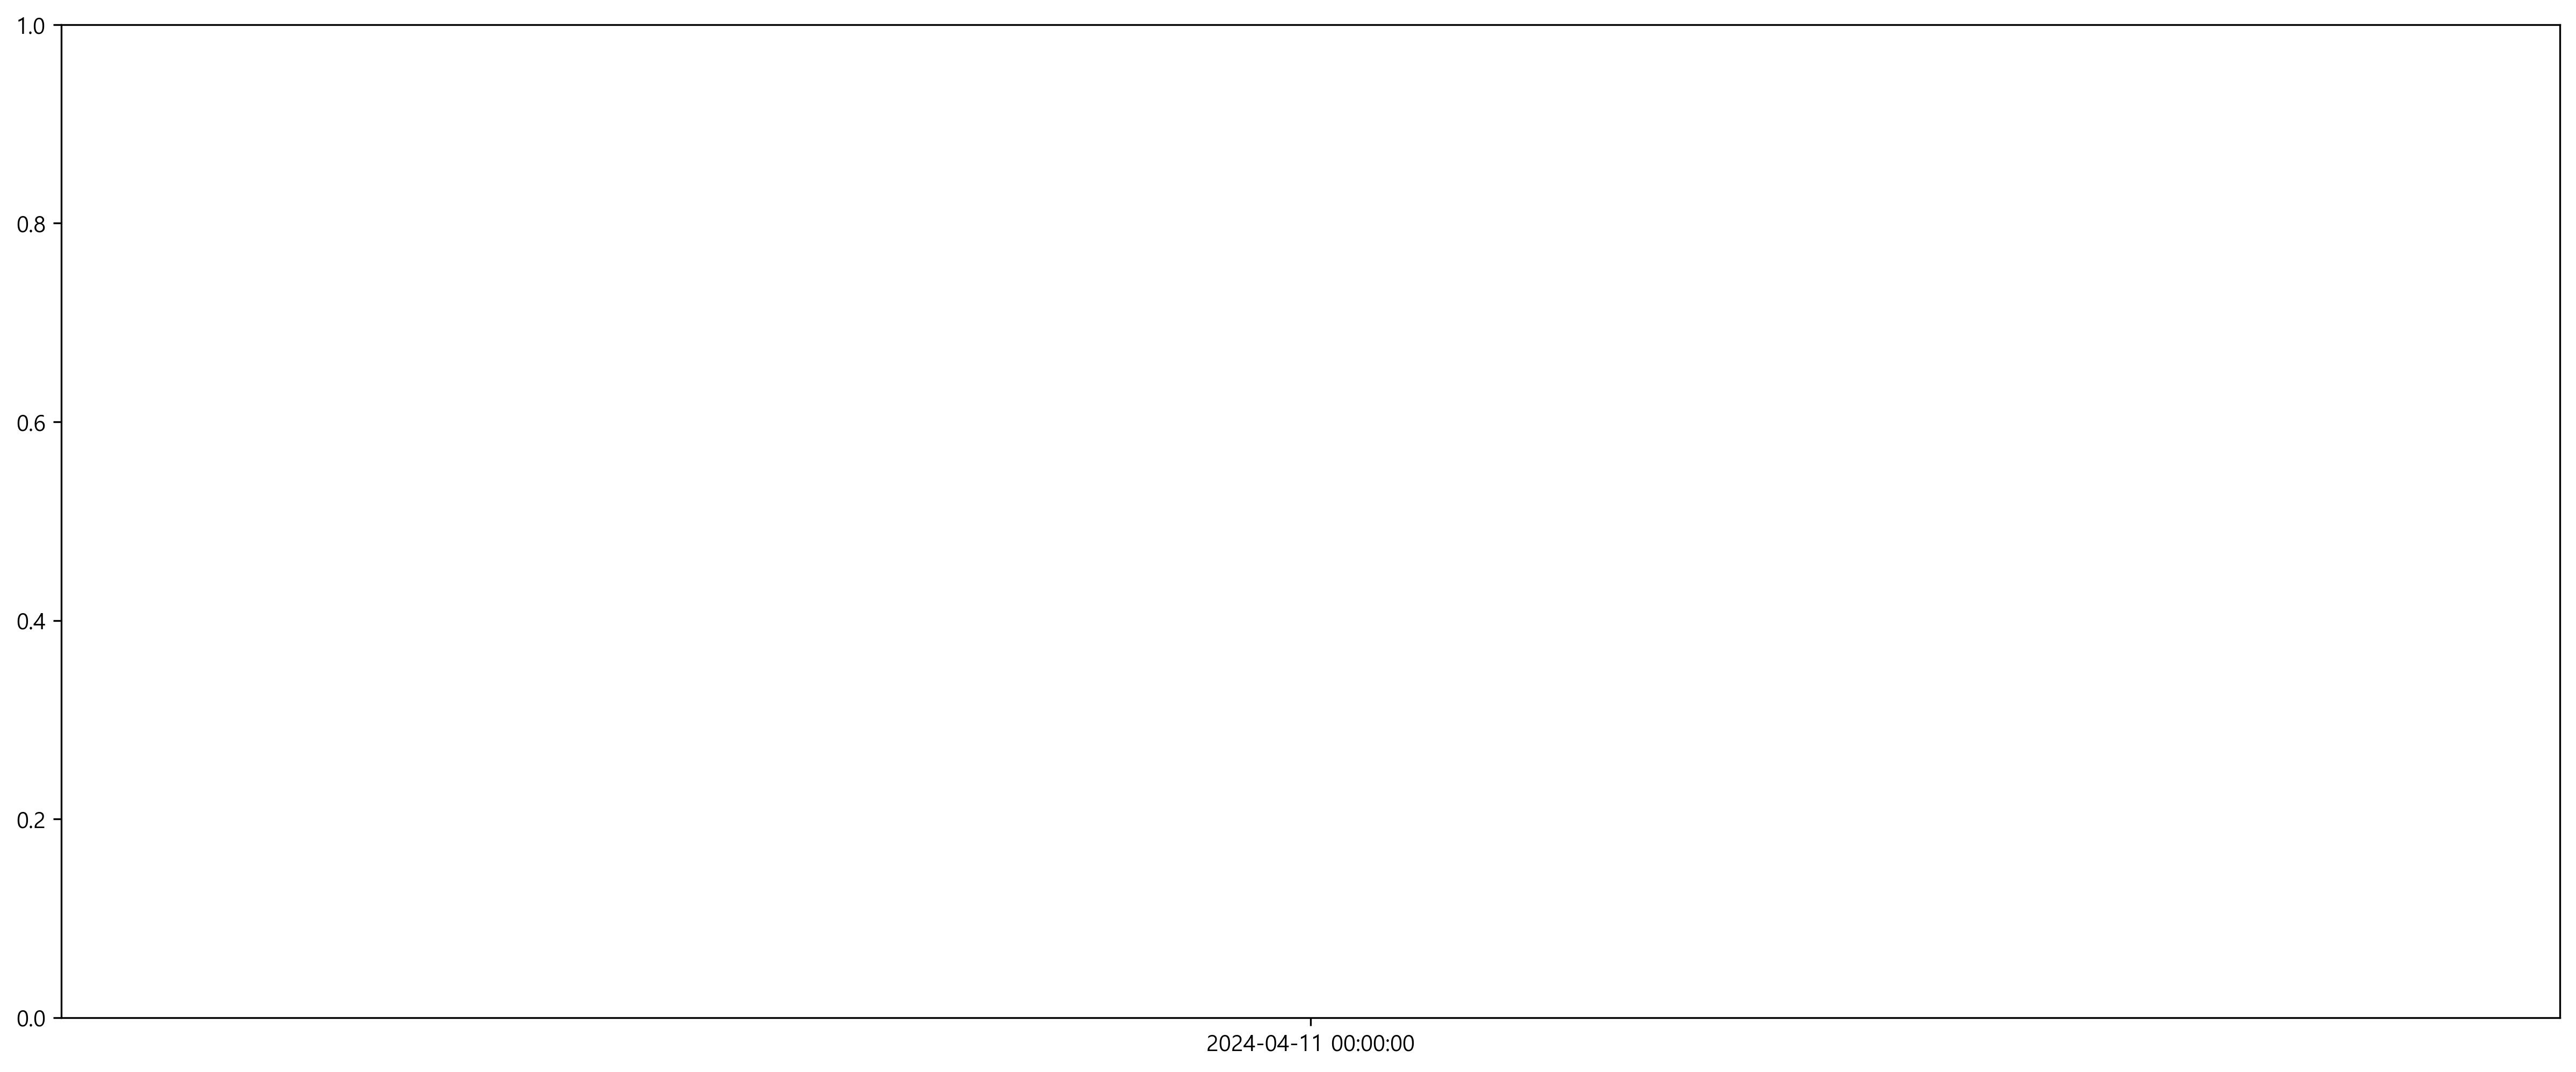

In [25]:
data = pd.read_csv('./data/j_before_feature_importance_with_datetime.csv')  # datetime 정보

plt.figure(figsize=(20, 8))

start_index = train_size + seq_len
end_index = start_index + len(y_test)

datetime_range = data['datetime'][start_index:end_index].values
# if len(datetime_range) < len(y_pred):
#   print("Warning: Datetime range is shorter than prediction length. Adjusting range.")
#   y_pred = y_pred[:len(da/tetime_range)]

plt.plot(datetime_range, y_test_ori, label='Actual')
plt.plot(datetime_range, y_pred_ori, label='Predicted')

plt.xticks([])
plt.xlabel('Datetime')
plt.ylabel('Outflow')
plt.title('Actual vs Predicted Outflow (LSTM)')
plt.legend()
plt.tight_layout()
plt.show()

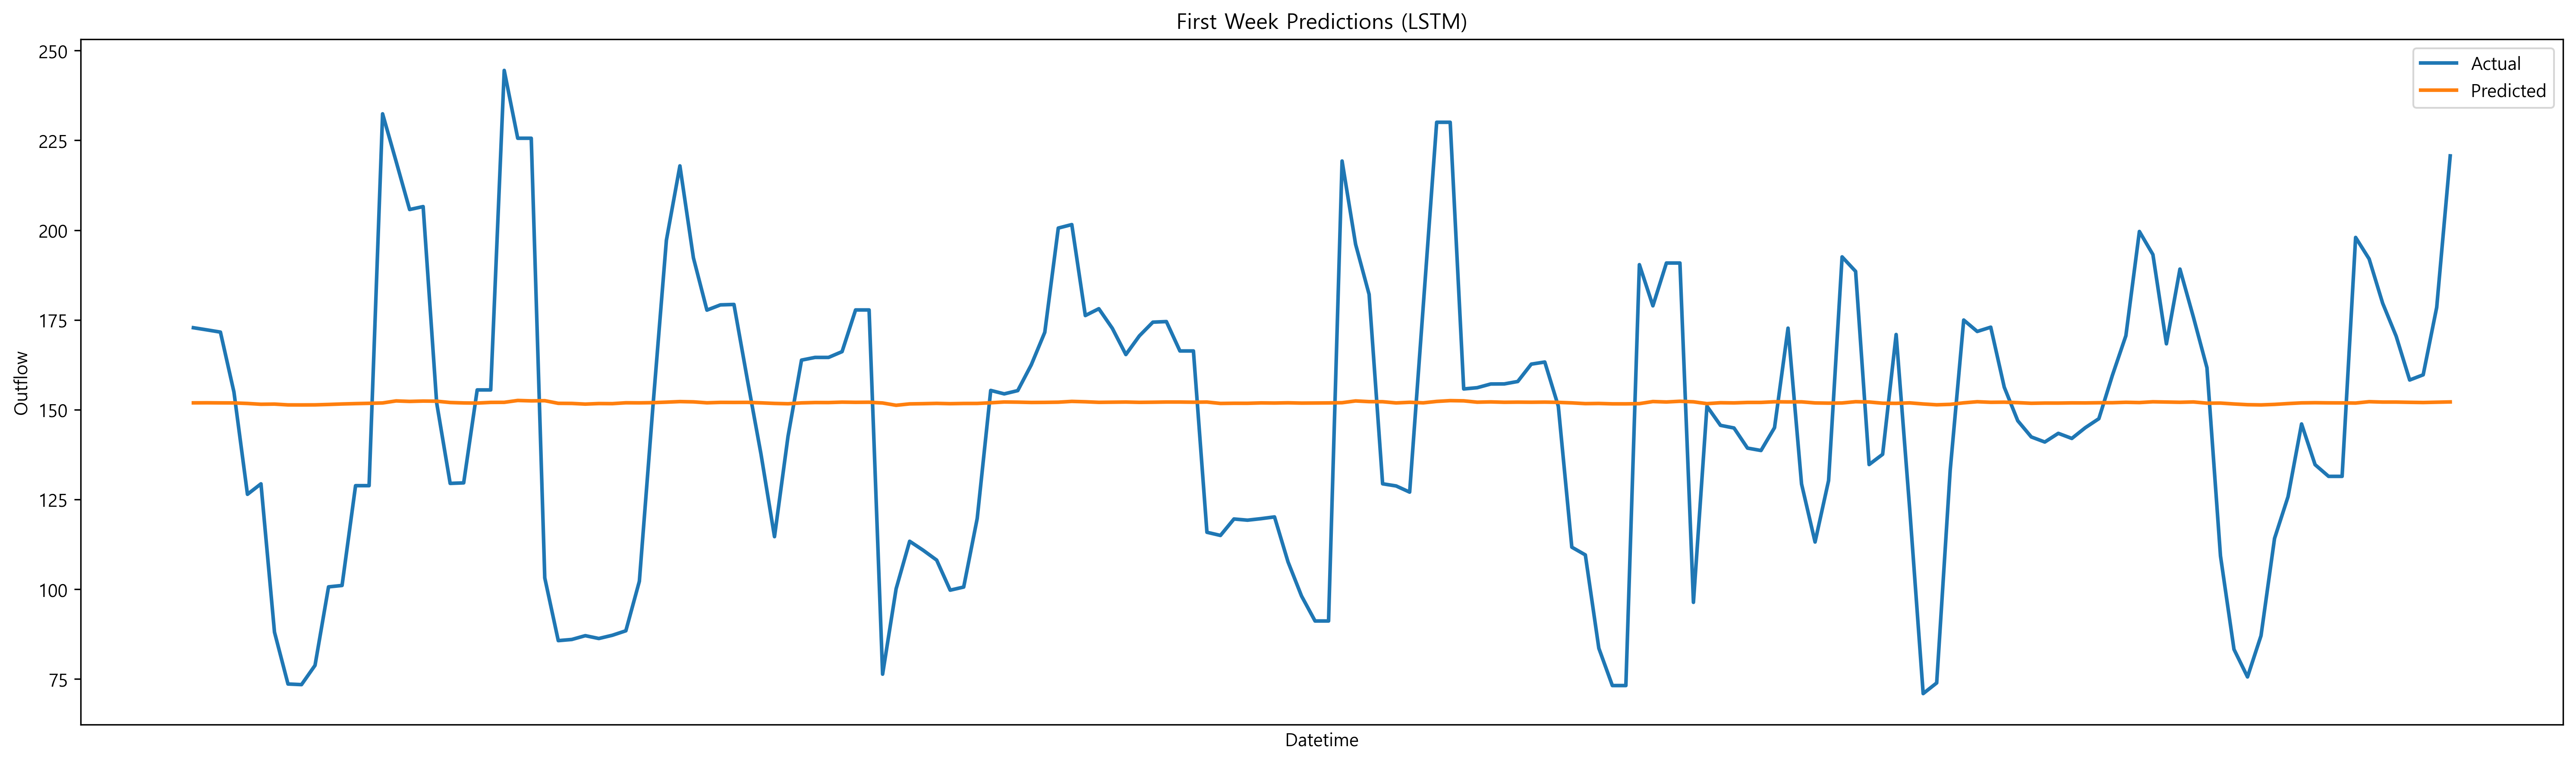

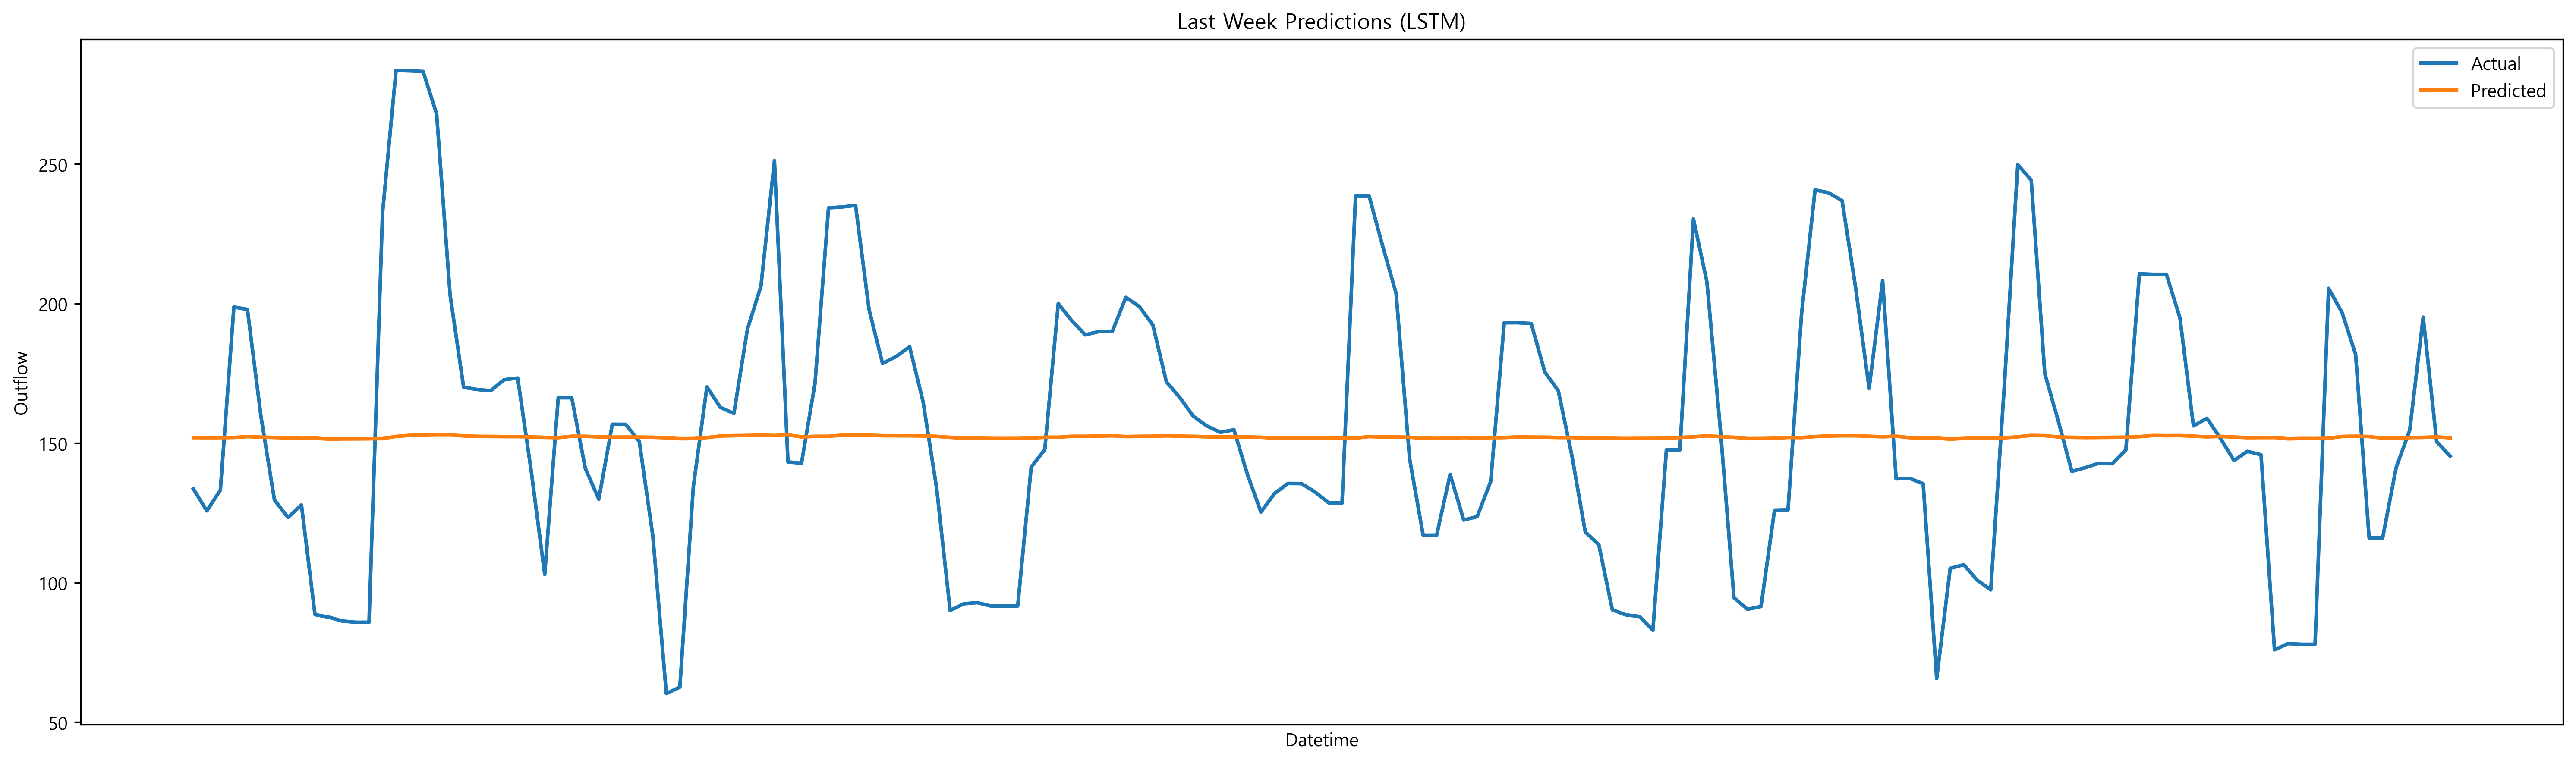

In [ ]:
def plot_predictions_weekly(y_true, y_pred, datetime_data, start_index, plot_title):
  plt.figure(figsize=(20, 6))

  datetime_range = datetime_data[start_index:start_index + 168].values  # 일주일 (168시간)

  y_true_plot = y_true[:168]
  y_pred_plot = y_pred[:168]

  plt.plot(datetime_range, y_true_plot, label='Actual')
  plt.plot(datetime_range, y_pred_plot, label='Predicted')

  plt.xlabel('Datetime')
  plt.ylabel('Outflow')
  plt.title(plot_title)
  plt.legend()
  plt.xticks([])
  plt.tight_layout()
  plt.show()

start_index_start = train_size + seq_len
plot_predictions_weekly(y_test_ori, y_pred_ori, data['datetime'], start_index_start, 'First Week Predictions (LSTM)')

start_index_end = train_size + seq_len + len(y_test) - 168
plot_predictions_weekly(y_test_ori[-168:], y_pred_ori[-168:], data['datetime'], len(data) - 168, 'Last Week Predictions (LSTM)')